In [10]:
# %%
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from keras import layers, models, regularizers, callbacks
from keras.api.optimizers import Adam
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetRegressor


# %%
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset
df = pd.read_csv("./lucas_pre.csv")

# Display basic information
print(f"Dataset shape: {df.shape}")

# Identify column types
target = "pH_H2O"
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target in numeric_cols:
    numeric_cols.remove(target)

categorical_cols = ["Depth", "LC", "LU", "USDA", "ISSS", "NUTS_0", "LC0_Desc", "LC1_Desc", "LU1_Desc"]
# Filter to only keep categorical columns that exist in the dataset
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Remove columns with too many unique values or too many missing values
filtered_cat_cols = []
for col in categorical_cols:
    if col in df.columns:
        if df[col].nunique() < 30 and df[col].isna().sum() / len(df) < 0.3:
            filtered_cat_cols.append(col)

print(f"Using {len(numeric_cols)} numeric columns and {len(filtered_cat_cols)} categorical columns")

# Drop rows where target is missing
df = df.dropna(subset=[target])

# Feature engineering - create new features
if "EC" in df.columns and "OC" in df.columns:
    df["EC_OC_ratio"] = df["EC"] / df["OC"].replace(0, 0.001)

if "Clay" in df.columns and "Sand" in df.columns:
    df["Clay_Sand_ratio"] = df["Clay"] / df["Sand"].replace(0, 0.001)

if "N" in df.columns and "P" in df.columns and "K" in df.columns:
    # NPK balance is important for soil chemistry
    if df["N"].notnull().sum() > 0 and df["P"].notnull().sum() > 0 and df["K"].notnull().sum() > 0:
        df["NPK_sum"] = df["N"] + df["P"] + df["K"]

if "CaCO3" in df.columns:
    # Soil pH is strongly related to CaCO3
    df["log_CaCO3"] = np.log1p(df["CaCO3"])

if "OC" in df.columns and "N" in df.columns:
    # C:N ratio is important for soil biology
    df["CN_ratio"] = df["OC"] / df["N"].replace(0, 0.001)

if "Clay" in df.columns and "OC" in df.columns:
    # Clay-organic matter interactions affect pH
    df["Clay_OC_interaction"] = df["Clay"] * df["OC"]

# Extract target values
y = df[target].values

# Update numeric columns after adding engineered features
numeric_cols = [col for col in df.select_dtypes(include=[np.number]).columns.tolist() if col != target]

# Create preprocessing pipeline
numeric_transformer = Pipeline(
    steps=[
        ("imputer", KNNImputer(n_neighbors=5)),
        ("power", PowerTransformer(method="yeo-johnson")),  # Better than StandardScaler for skewed data
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

# Combine all transformers
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_cols), ("cat", categorical_transformer, filtered_cat_cols)]
)

# Prepare features
X = df[numeric_cols + filtered_cat_cols]

# Split data before preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


Dataset shape: (18984, 28)
Using 15 numeric columns and 7 categorical columns


Processed feature shape: (15186, 134)


/Users/rafi/.local/share/mise/installs/python/3.12.7/lib/python3.12/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 11.33391| train_mae: 1.12398 | valid_mae: 1.1176  |  0:00:02s
epoch 1  | loss: 2.14895 | train_mae: 0.82363 | valid_mae: 0.81463 |  0:00:04s
epoch 2  | loss: 1.37683 | train_mae: 0.7878  | valid_mae: 0.77967 |  0:00:06s
epoch 3  | loss: 1.08761 | train_mae: 0.73164 | valid_mae: 0.72765 |  0:00:08s
epoch 4  | loss: 0.87201 | train_mae: 0.66631 | valid_mae: 0.66466 |  0:00:09s
epoch 5  | loss: 0.80383 | train_mae: 0.65015 | valid_mae: 0.64842 |  0:00:11s
epoch 6  | loss: 0.73191 | train_mae: 0.64027 | valid_mae: 0.6352  |  0:00:13s
epoch 7  | loss: 0.63805 | train_mae: 0.59869 | valid_mae: 0.60169 |  0:00:15s
epoch 8  | loss: 0.5887  | train_mae: 0.58661 | valid_mae: 0.58556 |  0:00:16s
epoch 9  | loss: 0.55727 | train_mae: 0.56881 | valid_mae: 0.57212 |  0:00:18s
epoch 10 | loss: 0.50758 | train_mae: 0.55225 | valid_mae: 0.54846 |  0:00:20s
epoch 11 | loss: 0.51045 | train_mae: 0.55627 | valid_mae: 0.56523 |  0:00:22s
epoch 12 | loss: 0.4829  | train_mae: 0.53697 | vali

/Users/rafi/.local/share/mise/installs/python/3.12.7/lib/python3.12/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Test Mean Absolute Error: 0.3847
R² Score: 0.8352

Feature Importances:
log_CaCO3: 0.1163
CaCO3 (20-30 cm): 0.0677
CN_ratio: 0.0505
Clay_Sand_ratio: 0.0485
CaCO3: 0.0439
N: 0.0245
NPK_sum: 0.0188
K: 0.0186
OC: 0.0157
EC_OC_ratio: 0.0128
LU: 0.0067
OC (20-30 cm): 0.0062
LC0_Desc: 0.0044
LU1_Desc: 0.0035
Depth: 0.0031
Elev: 0.0029
Clay_OC_interaction: 0.0028
NUTS_0: 0.0015
ISSS: 0.0013
Silt: 0.0013
Clay: 0.0011
Ox_Fe: 0.0008
P: 0.0008
Sand: 0.0007
Coarse: 0.0006
EC: 0.0004
Ox_Al: 0.0001
USDA: 0.0000


KeyError: 'val_loss'

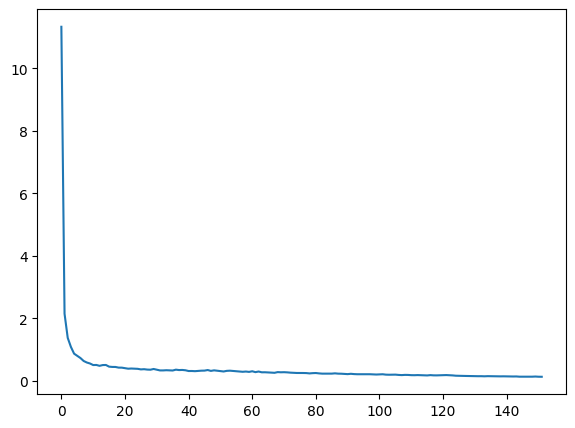

In [ ]:
# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed feature shape: {X_train_processed.shape}")

# Convert to numpy arrays if they aren't already
X_train_np = X_train_processed
X_test_np = X_test_processed
# Reshape target variables to 2D for TabNet
y_train_np = y_train.reshape(-1, 1)
y_test_np = y_test.reshape(-1, 1)

# Define TabNet model with hyperparameters
tabnet_model = TabNetRegressor(
    n_d=64,  # Width of the decision prediction layer
    n_a=64,  # Width of the attention embedding for each mask
    n_steps=5,  # Number of steps in the architecture (feature selection steps)
    gamma=1.5,  # This is the coefficient for feature reusage in the masks
    n_independent=2,  # Number of independent GLU layers at each step
    n_shared=2,  # Number of shared GLU layers at each step
    cat_idxs=[],  # No categorical indices since we've already preprocessed
    cat_dims=[],  # No categorical dimensions
    cat_emb_dim=[],  # No categorical embedding dimensions
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=0.01),
    scheduler_params=dict(
        mode="min",
        # patience=10,
        min_lr=1e-5,
        factor=0.5,
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    mask_type="entmax",  # "sparsemax" or "entmax" for more flexibility in feature selection
    lambda_sparse=1e-4,  # Sparsity regularization
    # max_epochs=200,  # Maximum number of epochs (with early stopping)
    # patience=20,  # Early stopping patience
    # batch_size=1024,  # Larger batch size for faster training
    # virtual_batch_size=128,  # Size of the mini-batches used for "Ghost Batch Normalization"
    # num_workers=0,  # Number of workers for data loading
    # drop_last=False,  # Whether to drop the last incomplete batch
    verbose=1,  # Verbosity level
)

# Fit the model
tabnet_model.fit(
    X_train_np,
    y_train_np,
    eval_set=[(X_train_np, y_train_np), (X_test_np, y_test_np)],
    eval_name=["train", "valid"],
    eval_metric=["mae"],
    patience=20,
    max_epochs=200,
    batch_size=64,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# Predict on test data
y_pred = tabnet_model.predict(X_test_np)

# Ensure predictions match the target shape for evaluation
y_test_flat = y_test_np.ravel()
y_pred_flat = y_pred.ravel()

# Evaluate the model
mae = mean_absolute_error(y_test_flat, y_pred_flat)
r2 = r2_score(y_test_flat, y_pred_flat)

print(f"Test Mean Absolute Error: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

# Get feature importances (one of TabNet's advantages)
feature_importances = tabnet_model.feature_importances_

# If you have the original feature names
if "numeric_cols" in locals() and "filtered_cat_cols" in locals():
    feature_names = numeric_cols + filtered_cat_cols
    # Create a dictionary of feature importances
    importance_dict = dict(zip(feature_names, feature_importances))
    # Sort by importance
    sorted_importances = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1], reverse=True)}

    print("\nFeature Importances:")
    for feature, importance in sorted_importances.items():
        print(f"{feature}: {importance:.4f}")

# %%
# Plot training history
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(tabnet_model.history.history["loss"])
plt.plot(tabnet_model.history.history["val_loss"])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")

plt.subplot(1, 2, 2)
plt.plot(tabnet_model.history.history["mae"])
plt.plot(tabnet_model.history.history["val_mae"])
plt.title("Model MAE")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper right")
plt.tight_layout()
plt.show()

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "r--")
plt.xlabel("Actual pH")
plt.ylabel("Predicted pH")
plt.title(f"Actual vs Predicted pH (R² = {r2:.4f})")
plt.grid(True)
plt.tight_layout()
plt.show()
